In [1]:
# coding=utf-8
import os 
import sys 
sys.path.append('../model')
import numpy as np 
from PIL import Image

import torch 
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import transformer # model

def consistent_mask(m1, m2, o1, o2) : 
    '''
    Produce masks that are cycle-consistent with flow
    
    Input: masks (m1 and m2) and flows (o1 and o2) predicted for both images 
    Output: masks that are cycle-consistent with flow prediction (m1_final, m2_final)
    '''
    flow12 = (o1.narrow(0, 0, 2).unsqueeze(0).permute(0, 2, 3, 1) - 0.5) * 2 
    flow21 = (o2.narrow(0, 0, 2).unsqueeze(0).permute(0, 2, 3, 1) - 0.5) * 2 
    

    m1_warp = F.grid_sample(torch.from_numpy(m1.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow21, mode='bilinear').numpy().squeeze()
    m2_consist = m1_warp  * m2

    m1_back = F.grid_sample(torch.from_numpy(m2_consist.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow12, mode='bilinear')
    m1_final  = (m1 * m1_back.squeeze().numpy() )

    m2_final = F.grid_sample(torch.from_numpy(m1_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow21, mode='bilinear')
    m2_final = (m2 * m2_final.squeeze().numpy() )
    return m1_final, m2_final

def resize(I, img_size, stride=16) : 
    '''
    Resize images 
    1. Each dimension can be divided by stride (16)
    2. largest dimension is defined by img_size
    3. keeping aspect ratio
    
    Input: masks (m1 and m2) and flows (o1 and o2) predicted for both images 
    Output: masks that are cycle-consistent with flow prediction (m1_final, m2_final)
    '''
    w, h = I.size
    ratio = max(1.0 * w / img_size, 1.0 * h / img_size)
    
    new_w = int(round(w / ratio / stride)) * stride
    new_h = int(round(h / ratio / stride)) * stride
    return I.resize((new_w, new_h), resample=2)


### Load models

In [2]:
## set gpu
device = torch.device('cuda')

## load Moco feature
backbone = models.resnet50(pretrained=False)   
resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3']
resnet_module_list = [getattr(backbone,l) for l in resnet_feature_layers]
last_layer_idx = resnet_feature_layers.index('layer3')
backbone = torch.nn.Sequential(*resnet_module_list[:last_layer_idx+1])

## load pre-trained weight
resume_path_segswap= '../model/hard_mining_neg5.pth'
pos_weight = 0.1
feat_weight = 1
dropout = 0.1
activation = 'relu'
mode = 'small'
layer_type = ['I', 'C', 'I', 'C', 'I', 'N']
drop_feat = 0.1
feat_dim=1024

## model
netEncoder = transformer.TransEncoder(feat_dim,
                                      pos_weight = pos_weight,
                                      feat_weight = feat_weight,
                                      dropout= dropout,
                                      activation=activation,
                                      mode=mode,
                                      layer_type = layer_type,
                                      drop_feat = drop_feat) 

netEncoder.cuda()

print ('Loading net weight from {}'.format(resume_path_segswap))
param = torch.load(resume_path_segswap)
backbone.load_state_dict(param['backbone'])
netEncoder.load_state_dict(param['encoder'])
backbone.eval()
netEncoder.eval()
backbone.cuda()
netEncoder.cuda()

Loading net weight from ../model/hard_mining_neg5.pth


TransEncoder(
  (net): Encoder(
    (feat_proj): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (drop_feat): Dropout2d(p=0.1, inplace=False)
    (encoder_blocks): ModuleList(
      (0): EncoderLayerBlock(
        (layer1): EncoderLayerInnerAttention(
          (inner_encoder_layer): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=256, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (posEncoder): PositionEncodingSine2D()
        )


### set a pair of images

In [3]:
img_dir = '../data/Brueghel/Image/'
image2 = 'Paradise_with_Fall_of_Man__Brentford_.png'
image1 = 'Paradise_Landscape_with_Noah_s_Ark__Los_Angeles__J._Paul_Getty_Museum_.png'
img_size = 1120
I1 = Image.open(os.path.join(img_dir, image1)).convert('RGB')
I2 = Image.open(os.path.join(img_dir, image2)).convert('RGB')

### Get Predictions

In [4]:
norm_mean, norm_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transformINet = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])
tensor1 = resize(I1, img_size)
tensor2 = resize(I2, img_size)


tensor1 = transformINet(tensor1).unsqueeze(0).cuda()
tensor2 = transformINet(tensor2).unsqueeze(0).cuda()


with torch.no_grad() : 
    feat1 = backbone( tensor1 ) ## features
    feat1 = F.normalize(feat1) ## l2 normalization
    feat2 = backbone( tensor2 ) ## features 
    feat2 = F.normalize(feat2) ## l2 normalization
    out1, out2 = netEncoder(feat1, feat2) ## predictions
    m1_final, m2_final = consistent_mask(out1[0, 2].cpu().numpy(), out2[0, 2].cpu().numpy(), out1[0].cpu(), out2[0].cpu())
    

/root/py36torch17/lib64/python3.6/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


/root/py36torch17/lib64/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


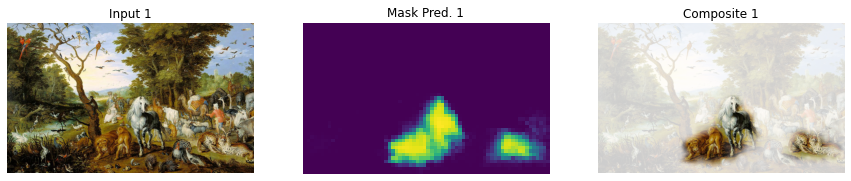

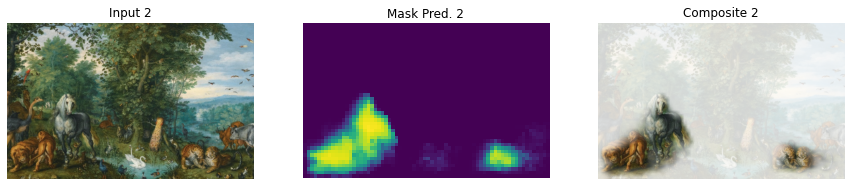

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline 


arr1 = np.array(I1)
m1_up = F.interpolate(torch.from_numpy(m1_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), size=(arr1.shape[0], arr1.shape[1]), mode='bilinear').numpy().squeeze()
m1_up = np.clip(m1_up * 255 + 50, a_min=50, a_max=255)
m1_up = m1_up.astype(np.uint8).reshape(arr1.shape[0], arr1.shape[1], 1)
arr1_mask = np.concatenate((arr1, m1_up), axis=2)
Image.fromarray(arr1_mask).save('I1_mask_swap.png')
I1.save('I1_org.png')
np.save('m1_final.npy', m1_final)

arr2 = np.array(I2)
m2_up = F.interpolate(torch.from_numpy(m2_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), size=(arr2.shape[0], arr2.shape[1]), mode='bilinear').numpy().squeeze()
m2_up = np.clip(m2_up * 255 + 50, a_min=50, a_max=255)
m2_up = m2_up.astype(np.uint8).reshape(arr2.shape[0], arr2.shape[1], 1)
arr2_mask = np.concatenate((arr2, m2_up), axis=2)
Image.fromarray(arr2_mask).save('I2_mask_segswap.png')
I2.save('I2_org.png')
np.save('m2_final.npy', m2_final)



f = plt.figure(figsize=(15, 32))
f.add_subplot(1, 3, 1)
plt.imshow(I1)
plt.axis('off')
plt.title("Input 1")

f.add_subplot(1, 3, 2)
plt.imshow(m1_final)
plt.axis('off')
plt.title("Mask Pred. 1")

f.add_subplot(1, 3, 3)
plt.imshow(arr1_mask)
plt.axis('off')
plt.title("Composite 1")
plt.show()

f = plt.figure(figsize=(15, 32))
f.add_subplot(1, 3, 1)
plt.imshow(I2)
plt.axis('off')
plt.title("Input 2")

f.add_subplot(1, 3, 2)
plt.imshow(m2_final)
plt.axis('off')
plt.title("Mask Pred. 2")

f.add_subplot(1, 3, 3)
plt.imshow(arr2_mask)
plt.axis('off')
plt.title("Composite 2")
plt.show()